# Computational Replicability in Science

- Modern scientists use computation.
- Facing "reproducibility crisis".
- Irreproducibility can be due to software
  - 80% of experiments sampled didn't work.

- **Repeatable**: same computational environment, same code
  - `./run ; ./run` gives a similar result
- **Replicable**: **different** computational environment, same code
  - Anyone can `./run` and get a similar result
- **Reproducible**: **different** computational environment, **different** code
  - Anyone can write their own version and get a similar result
- Reproducibility implies replicability implies repeatability.

- Reproducibility is the "holy grail", but not automatically testable.
- Focus on just making software repeatability.

- Short-term repeatability:
  - don't use hard-coded paths
  - seed PRNG
  - consistent parallel program schedule

- Software decays over time, even if the source code is unchanged, due to changes in the computational environment.
- Replicability (also "bit rot"):
  - use "repeatbility tools": Docker, VM, Conda
  - code quality
  - skill
  - staleness
 - **Goal:** predict replicability based on code and prior history of replication.
   - Use this to decide what software to test.

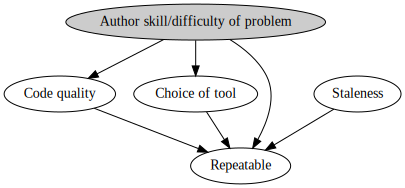

In [36]:
import graphviz
dot = graphviz.Digraph()
dot.node("skill", "Author skill/difficulty of problem",
         fillcolor="#cccccc", style="filled")
dot.node("qual0", "Code quality")
dot.node("qual1", "Choice of tool")
dot.node("rep", "Repeatable")
dot.node("staleness", "Staleness")
dot.edge("skill", "qual0")
dot.edge("qual0", "rep")
dot.edge("skill", "qual1")
dot.edge("qual1", "rep")
dot.edge("staleness", "rep")
dot.edge("skill", "rep")
dot

- Can't test today's code 1, 5, 10 years in the future.
  - Instead test 1, 5, 10 year ago code today.

- Author skill is a classic confounding variable.
- [Developers who use spaces get paid more!](https://stackoverflow.blog/2017/06/15/developers-use-spaces-make-money-use-tabs/)

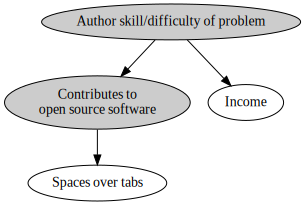

In [6]:
dot2 = graphviz.Digraph()
dot2.node("skill", "Author skill/difficulty of problem", fillcolor="#cccccc", style="filled")
dot2.node("spaces", "Spaces over tabs")
dot2.node("oss", "Contributes to\nopen source software", fillcolor="#cccccc", style="filled")
dot2.node("income", "Income")
dot2.edge("skill", "oss")
dot2.edge("skill", "income")
dot2.edge("oss", "spaces")
dot2

- How to control for "developer skill", which is complex and unobserved?
  - Use multiple versions of the same project!
  - bewteen- and within-subjects design

```python
for experiment in registry:
    for version in experiment:
        execution = execute(version)
        data.append((
            execution.staleness,
            version.source_tree,
            experiment.id,
        ))
```

|Experiment ID|Code quality|Date published|Repeatable?|
|----|----|----|---|
|1|good|2014|no|
|1|bad|2015|yes|
|1|good|2018|yes|
|1|...|...|...|
|2|bad|207|no|
|...|...|...|...|

- Suppose "skill -> follow best practices -> code quality"
- Can we determine causal best practices?
  - If you use Docker, linter, etc., your code will be more likely to be reproducible.
- Skill is a fork, but we have repeated measurements of it, so we can infer it.
- Don't condition on code quality (fungus)!
- Goodhart's law: "When a measure becomes a target, it ceases to be a good measure"
- DAG might be incomplete!
  - Skill could be complex and multi-dimensional. "skill2 (unobserved) -> best practices -> replicability"
  - Do a intervention RCT later.
- Software engineering ~ medicine

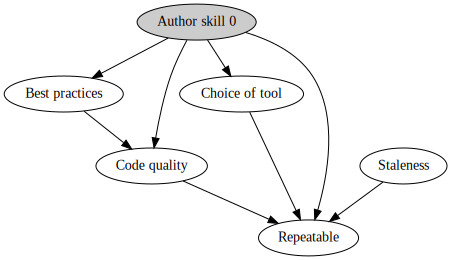

In [37]:
import graphviz
dot = graphviz.Digraph()
dot.node("skill", "Author skill 0", fillcolor="#cccccc", style="filled")
dot.node("bp", "Best practices")
dot.node("qual0", "Code quality")
dot.node("qual1", "Choice of tool")
dot.node("rep", "Repeatable")
dot.edge("skill", "bp")
dot.node("staleness", "Staleness")
dot.edge("skill", "qual0")
dot.edge("qual1", "rep")
dot.edge("skill", "qual1")
dot.edge("bp", "qual0")
dot.edge("qual0", "rep")
dot.edge("staleness", "rep")
dot.edge("skill", "rep")
dot

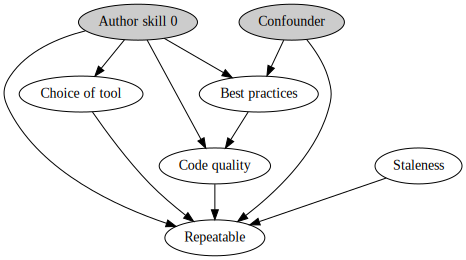

In [16]:
import graphviz
dot = graphviz.Digraph()
dot.node("skill", "Author skill 0", fillcolor="#cccccc", style="filled")
dot.node("skill1", "Confounder", fillcolor="#cccccc", style="filled")
dot.node("bp", "Best practices")
dot.node("qual0", "Code quality")
dot.edge("skill1", "bp")
dot.edge("skill1", "rep")
dot.node("qual1", "Choice of tool")
dot.node("rep", "Repeatable")
dot.edge("skill", "bp")
dot.node("staleness", "Staleness")
dot.edge("skill", "qual0")
dot.edge("qual1", "rep")
dot.edge("skill", "qual1")
dot.edge("bp", "qual0")
dot.edge("qual0", "rep")
dot.edge("staleness", "rep")
dot.edge("skill", "rep")
dot

- Model bit rot as exponential decay or logistic with an exponential breaking-point?
- Exponential decay assumes constant rate
  - What about "infant mortality"
  - <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Bathtub_curve.svg/1024px-Bathtub_curve.svg.png" style="width: 10vw;"/>

In [19]:
import pymc
import yaml
import pandas
from pathlib import Path
import numpy

random_seed = 0
wf_apps = yaml.load(Path("../data.yaml").read_text(), Loader=yaml.UnsafeLoader)
def drop_keys(dct, drop_keys):
    return {
        key: val
        for key, val in dct.items()
        if key not in drop_keys
    }

def prefix_keys(dct, prefix_key):
    return {
        (prefix_key, key): val
        for key, val in dct.items()
    }
df = pandas.DataFrame.from_records(
    [
        {
            **prefix_keys(drop_keys(wf_app.__dict__, {"revisions"}), "wf_app"),
            **prefix_keys(drop_keys(revision.__dict__, {"executions", "workflow_app"}), "revision"),
            **prefix_keys(drop_keys(execution.__dict__, {"revisions"}), "execution"),
        }
        for wf_app_no, wf_app in enumerate(wf_apps)
        for revision in wf_app.revisions
        for execution in revision.executions
    ],
)
df.columns = pandas.MultiIndex.from_tuples(df.columns)
df["wf_app", "id"] = df["wf_app", "url"].astype("category").cat.codes
df["revision", "id"] = df["revision", "url"].astype("category").cat.codes
df["execution", "id"] = df.index
df["execution", "success"] = df["execution", "status_code"] == 0
df["execution", "total_cpu_time"] = df["execution", "system_cpu_time"] + df["execution", "user_cpu_time"]
df["execution", "staleness"] = (df["revision", "datetime"] - df["execution", "datetime"]) / numpy.timedelta64(1, 'Y')

min_number_of_revisions = 3
is_wf_id_plentiful = (
    df[[("wf_app", "id"), ("revision", "id")]]
    .drop_duplicates()
    .groupby(("wf_app", "id"))
    .aggregate(len)
    [("revision", "id")]
    > min_number_of_revisions
)

good_executions_mask = df["execution", "wall_time"] > numpy.timedelta64(100, "ms")
min_number_of_revisions = 3
is_wf_id_plentiful = (
    df[good_executions_mask]
    [[("wf_app", "id"), ("revision", "id")]]
    .drop_duplicates()
    .groupby(("wf_app", "id"))
    .aggregate(len)
    [("revision", "id")]
    > min_number_of_revisions
)
plentiful_wf_set = set(is_wf_id_plentiful[is_wf_id_plentiful].index)
plentiful_wf_mask = df[("wf_app", "id")].isin(plentiful_wf_set)
print(f"Throwing out workflows with fewer than {min_number_of_revisions}")
print(f"  {df[('wf_app', 'id')].nunique()} to {len(plentiful_wf_set)} workflows")
print(f"  {len(df)} to {sum(plentiful_wf_mask)} executions")

wf_id_map = dict(enumerate(sorted(list(plentiful_wf_set))))
wf_id_map_reverse = dict(map(lambda x: x[::-1], wf_id_map.items()))

Throwing out workflows with fewer than 3
  8 to 4 workflows
  49 to 43 executions


In [4]:
import matplotlib.pyplot as plt
import arviz

def fix_axes(ax, title):
    ax.set_xlim(df["execution", "staleness"].min() * 1.1, 0)
    ax.set_xlabel("Years")
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_ylabel("works = 1, fails = 0")
    ax.set_title(title)

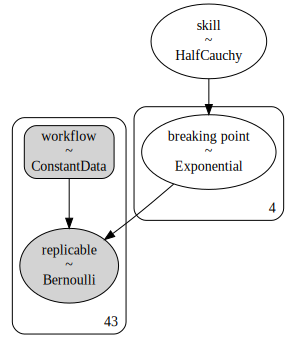

In [22]:
lin_time_model = pymc.Model()
with lin_time_model:
    wf_ids = list(map(wf_id_map_reverse.get, df[plentiful_wf_mask]["wf_app", "id"].values))
    w_idx = pymc.ConstantData("workflow", wf_ids)
    lam = pymc.HalfCauchy("skill", beta=1/20)
    breaking_point = pymc.Exponential("breaking point", lam=lam, shape=len(wf_id_map))
    p_t = pymc.Bernoulli(
        "replicable",
        p=pymc.math.sigmoid(df[plentiful_wf_mask]["execution", "staleness"].values + breaking_point[w_idx]),
        observed=df[plentiful_wf_mask]["execution", "success"],
    )
pymc.model_to_graphviz(lin_time_model)

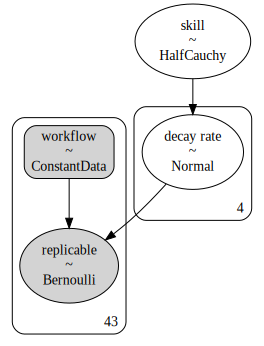

In [23]:
unpooled_exp_decay_model = pymc.Model()
with unpooled_exp_decay_model:
    wf_ids = list(map(wf_id_map_reverse.get, df[plentiful_wf_mask]["wf_app", "id"].values))
    w_idx = pymc.ConstantData("workflow", wf_ids)
    rootlam_mean = pymc.HalfCauchy("skill", beta=1/20)
    rootlam = pymc.Normal("decay rate", rootlam_mean, 5, shape=len(wf_id_map))
    lam = rootlam**2
    p_t = pymc.Bernoulli(
        "replicable",
        p=pymc.math.exp(lam[w_idx] * df[plentiful_wf_mask]["execution", "staleness"].values),
        observed=df[plentiful_wf_mask]["execution", "success"].values,
    )
pymc.model_to_graphviz(unpooled_exp_decay_model)

In [24]:
exp_decay_model = pymc.Model()
with exp_decay_model:
    lam = pymc.HalfCauchy("lam", beta=1/2)
    p_t = pymc.Bernoulli(
        "p_t",
        p=pymc.math.exp(lam * df[plentiful_wf_mask]["execution", "staleness"]),
        observed=df[plentiful_wf_mask]["execution", "success"],
    )
unpooled_exp_decay_model = pymc.Model()
with unpooled_exp_decay_model:
    wf_ids = list(map(wf_id_map_reverse.get, df[plentiful_wf_mask]["wf_app", "id"].values))
    w_idx = pymc.ConstantData("w_idx", wf_ids)
    rootlam_mean = pymc.HalfCauchy("rootlam_mean", beta=1/20)
    rootlam_stddev = pymc.HalfCauchy("rootlam_stddev", beta=1/2)
    rootlam = pymc.Normal("rootlam", rootlam_mean, rootlam_stddev, shape=len(wf_id_map))
    lam = rootlam**2
    p_t = pymc.Bernoulli(
        "p_t",
        p=pymc.math.exp(lam[w_idx] * df[plentiful_wf_mask]["execution", "staleness"].values),
        observed=df[plentiful_wf_mask]["execution", "success"].values,
    )

Sampling: [lam, p_t]


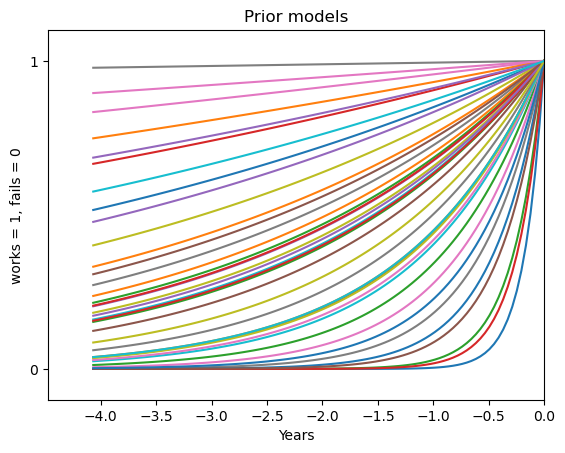

In [25]:
n_prior_samples = 40
with exp_decay_model:
    idata = pymc.sample_prior_predictive(samples=n_prior_samples, random_seed=random_seed)

n_times = 100
lin_times = numpy.linspace(df[plentiful_wf_mask]["execution", "staleness"].values.min(), 0, n_times)

y_rows = numpy.exp(numpy.tile(lin_times, (n_prior_samples, 1)) * idata.prior.lam.values.T)
for y_row in y_rows:
    plt.plot(lin_times, y_row)
fix_axes(plt.gca(), title="Prior models")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 5 seconds.


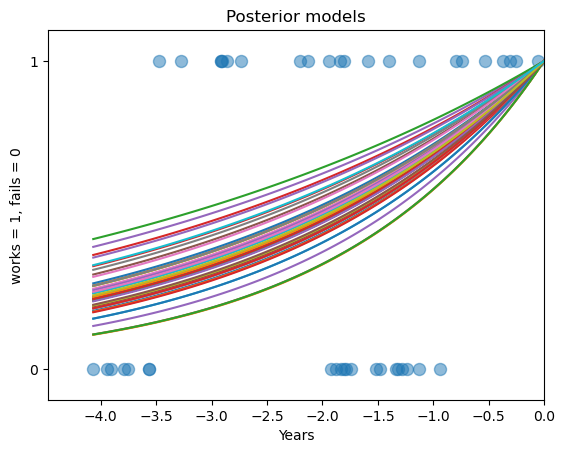

In [26]:
n_posterior_points = 3000
with exp_decay_model:
    idata = pymc.sample(n_posterior_points, random_seed=random_seed)
    
n_posterior_samples = 50
posterior_lam = idata.posterior.lam[1, -n_posterior_samples:].values[:, numpy.newaxis]
y_rows = numpy.exp(numpy.tile(lin_times, (n_posterior_samples, 1)) * posterior_lam)
for y_row in y_rows:
    plt.plot(lin_times, y_row)
plt.scatter(
    df[plentiful_wf_mask]["execution", "staleness"],
    df[plentiful_wf_mask]["execution", "success"],
    s=75,
    alpha=1/2,
)
fix_axes(plt.gca(), title="Posterior models")

In [27]:
wf_id_map = dict(enumerate(sorted(list(plentiful_wf_set))))
wf_id_map_reverse = dict(map(lambda x: x[::-1], wf_id_map.items()))

Sampling: [p_t, rootlam, rootlam_mean, rootlam_stddev]


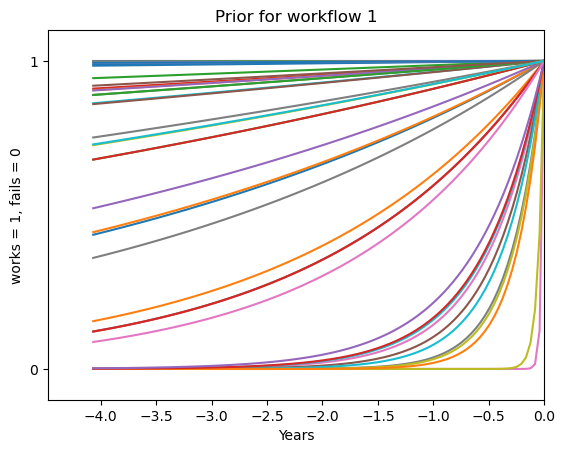

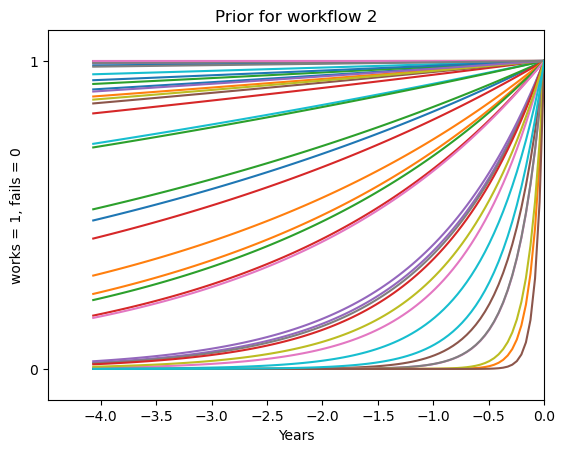

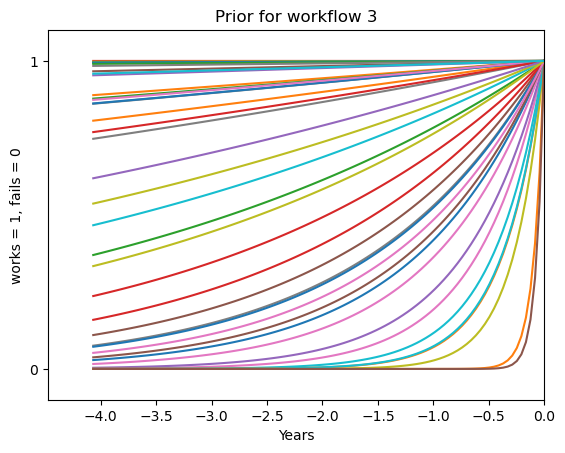

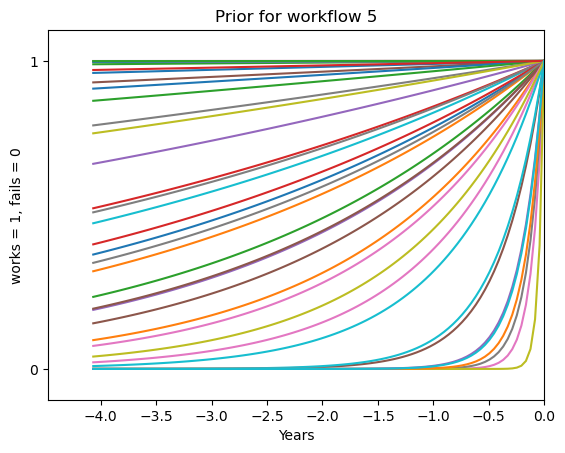

In [28]:
with unpooled_exp_decay_model:
    idata = pymc.sample_prior_predictive(samples=n_prior_samples, random_seed=random_seed)
for mcmc_wf_id, wf_id in wf_id_map.items():
    rootlam = idata.prior.rootlam.values.T[mcmc_wf_id]
    y_rows = numpy.exp(rootlam**2 * lin_times[numpy.newaxis, :])
    fig = plt.figure()
    ax = fig.gca()
    for y_row in y_rows:
        ax.plot(lin_times, y_row)
    fix_axes(ax, f"Prior for workflow {wf_id}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rootlam_mean, rootlam_stddev, rootlam]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 17 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6746, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


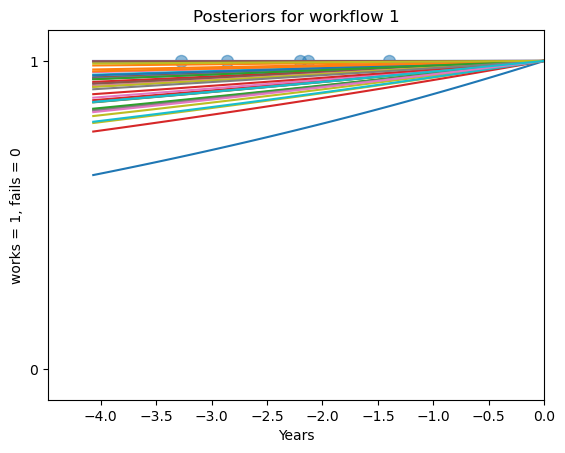

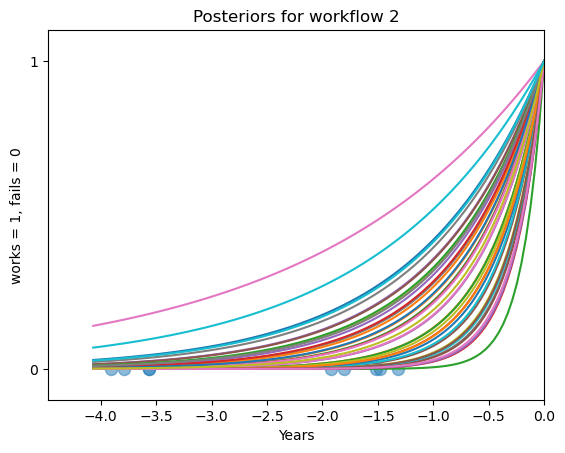

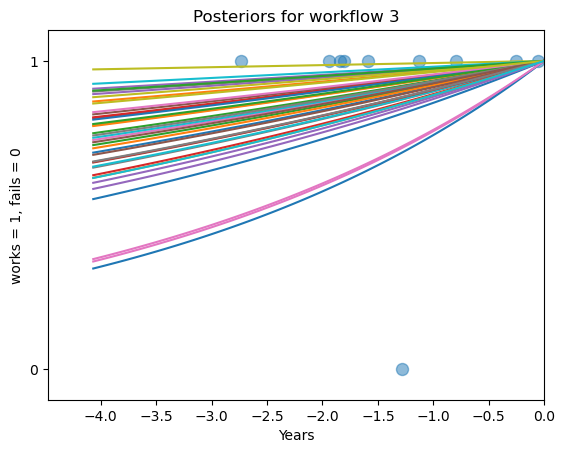

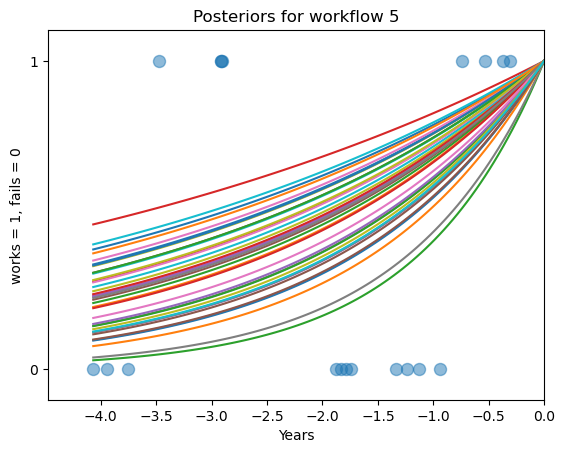

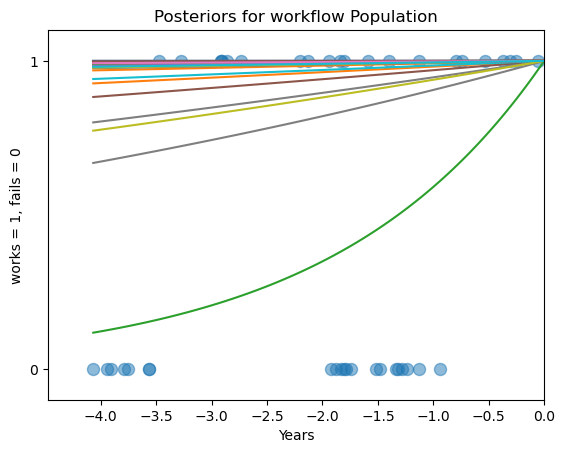

In [29]:
with unpooled_exp_decay_model:
    idata = pymc.sample(n_posterior_points, random_seed=random_seed)
for mcmc_wf_id, wf_id in wf_id_map.items():
    rootlam = idata.posterior.rootlam[-1:, -n_prior_samples:, mcmc_wf_id].T
    y_rows = numpy.exp(rootlam**2 * lin_times[numpy.newaxis, :])
    fig = plt.figure()
    ax = fig.gca()
    for y_row in y_rows:
        ax.plot(lin_times, y_row)
    ax.scatter(
        df[plentiful_wf_mask][df[plentiful_wf_mask]["wf_app", "id"] == wf_id]["execution", "staleness"],
        df[plentiful_wf_mask][df[plentiful_wf_mask]["wf_app", "id"] == wf_id]["execution", "success"],
        s=75,
        alpha=1/2,
    )
    fix_axes(ax, f"Posteriors for workflow {wf_id}")

rootlam = idata.posterior.rootlam_mean[-1:, -n_prior_samples:].T
y_rows = numpy.exp(rootlam**2 * lin_times[numpy.newaxis, :])
fig = plt.figure()
ax = fig.gca()
for y_row in y_rows:
    ax.plot(lin_times, y_row)
ax.scatter(
    df[plentiful_wf_mask]["execution", "staleness"],
    df[plentiful_wf_mask]["execution", "success"],
    s=75,
    alpha=1/2,
)
fix_axes(ax, f"Posteriors for workflow Population")

In [30]:
import matplotlib
import random
_ten_colors = list(matplotlib.colormaps["tab10"].colors)
random.shuffle(_ten_colors)
def rand_color(idx, total):
    if total < 10:
        return _ten_colors[idx]
    else:
        raise NotImplementedError("Not implemented for more than 10 colors")

(1.0, 3.0)

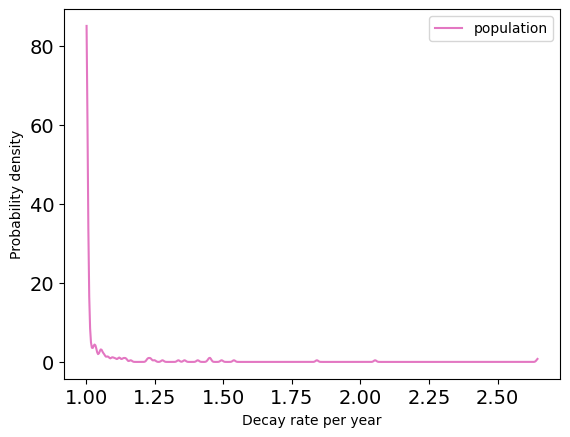

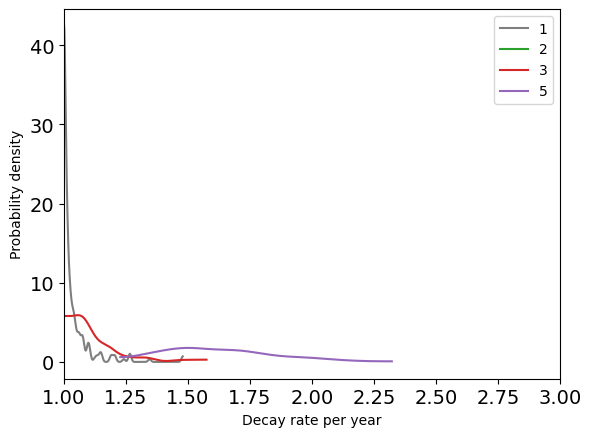

In [31]:
fig = plt.figure()
ax = fig.gca()
arviz.plot_kde(
    numpy.exp(idata.posterior.rootlam_mean[-1, :200].values**2),
    rug=False,
    ax=ax,
    plot_kwargs=dict(
        color=rand_color(len(plentiful_wf_set), len(plentiful_wf_set) + 1), 
    ),
    label="population",
    legend=True,
)
ax.set_xlabel("Decay rate per year")
ax.set_ylabel("Probability density")

fig = plt.figure()
ax = fig.gca()
for mcmc_wf_id, wf_id in wf_id_map.items():
    arviz.plot_kde(
        values=numpy.exp(idata.posterior.rootlam[-1, :200, mcmc_wf_id].values**2),
        ax=ax,
        plot_kwargs=dict(
            color=rand_color(mcmc_wf_id, len(plentiful_wf_set) + 1), 
        ),
        label=wf_id,
        #legend=False,
        #quantiles=[0.25, 0.5, 0.75],
    )
ax.set_xlabel("Decay rate per year")
ax.set_ylabel("Probability density")
ax.set_xlim(1.0, 3)

Let $p(t) = e^{-\lambda t}$

$$p(t+1) = e^{-\lambda (t+1)} = e^{-\lambda t}e^{-\lambda} = p(t) e^{-\lambda}$$

In [35]:
numpy.exp(-1.1), numpy.exp(-1.5)

(0.33287108369807955, 0.22313016014842982)